In [87]:
import os
import glob
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import json
from astropy.table import Table, Column, vstack
from astropy.cosmology import Planck15 as cosmo
from pathlib import Path
from scipy.stats import pearsonr as pr

# Create object to hold all data
all_data = {}

# Keywords for model parameters and latex symbols
keywords = {
    'plateau_duration': {'key': 'Tpt', 'errkey': 'e_Tpt', 'latex': 'Rest-frame plateau duration (days)'},
    'nickel_mass': {'key': 'MNi', 'errkey': 'e_MNi', 'latex': 'Nickel-56 Ejecta Mass (M$_{\\odot}$)'},
    'host_galaxy': {'key': 'Host'},
    'peak_luminosity': {'key': 'logLpeak', 'errkey': 'e_logLpeak', 'latex': 'Peak Luminosity (log(erg s$^{-1}$))'}
}

blast_keywords = {
    'local_sfd': {'latex': '$\Sigma$SFR ($M_\odot yr^{-1} kpc^{-2}$)'},
    'global_aperture_host_log_mass': {'latex': 'Global Stellar Mass (log($M_\odot$))'},
    'global_aperture_host_log_sfr': {'latex': 'Global Star-Formation Rate (log($M_\odot$ yr$^{-1}$))'},
    'global_aperture_host_log_ssfr': {'latex': 'Global Specific Star-Formation Rate (log(yr$^{-1}$))'},
    'local_aperture_host_logzsol': {'latex': 'Local Metallicity (log($Z/Z_\odot$))'},
    'global_aperture_host_logzsol': {'latex': 'Global Metallicity (log($Z/Z_\odot$))'},
    'local_aperture_host_log_age' :{'latex': 'Local Host Stellar Age'}
}

### Importing data from Valenti+2016 

In [88]:
valenti_phys = Table.read(os.path.join('data','valenti16','valenti_phys_bolometric.tsv'), format='ascii', delimiter='|')
valenti_lcpm = Table.read(os.path.join('data','valenti16','valenti_phys_lcpm.tsv'), format='ascii', delimiter='|')
valenti_meta = Table.read(os.path.join('data','valenti16','valenti_metadata.tsv'), format='ascii', delimiter='|')

# Merge metadata into physical parameters table
for col in valenti_meta.keys():
    if col not in valenti_phys.keys() and col not in ['LC','LC_param']:
        col_data = []
        for row in valenti_phys:
            mask = row['Name']==valenti_meta['Name']
            if len(valenti_meta[mask])==1:
                col_data.append(valenti_meta[mask][0][col])
            else:
                col_data.append(None)
        newcol = Column(col_data, name=col)
        valenti_phys.add_column(newcol)

# Sanitize keywords
for col in valenti_lcpm.keys():
    if col not in valenti_phys.keys() and col not in ['LC','LC_param']:
        col_data = []
        for row in valenti_phys:
            mask = row['Name']==valenti_lcpm['Name']
            if len(valenti_lcpm[mask])==1:
                col_data.append(valenti_lcpm[mask][0][col])
            else:
                col_data.append(None)
        newcol = Column(col_data, name=col)
        valenti_phys.add_column(newcol)

for key in ['MNi','e_MNi','Tpt','e_Tpt']:
    data = []
    for v in valenti_phys[key]:
        try:
            data.append(float(v))
        except TypeError:
            data.append(np.nan)
    valenti_phys[key] = data

# Append complete list of metadata into all_data
valenti_phys.meta['sample_name']='Valenti+2016'
all_data['valenti']=valenti_phys

C:\Users\jvasq\AppData\Local\Temp\ipykernel_11056\457811591.py:35: UserWarning: Warning: converting a masked element to nan.
  data.append(float(v))
C:\Users\jvasq\AppData\Local\Temp\ipykernel_11056\457811591.py:35: UserWarning: Warning: converting a masked element to nan.
  data.append(float(v))


### Importing data from Spiro+2014 

In [89]:
spiro_data = Table.read(os.path.join('data','spiro14','spiro_nickel'), format='ascii')

# Append complete list of metadata into all_data
spiro_data.meta['sample_name']='Spiro+2014'
all_data['spiro']=spiro_data

### Importing data from Anderson+2014 (https://ui.adsabs.harvard.edu/abs/2014ApJ...786...67A/abstract)

In [90]:
anderson_data = Table.read(os.path.join('data','anderson14','anderson_fit_data.txt'), format='ascii')

# Sanitize MNi-56
mass = [] ; err_mass = [] ; tpt = [] ; err_tpt = []
for row in anderson_data:
    dat = row['MNi']
    if '$' in dat:
        val = float(dat.split('$')[0])
        err = dat.split('$')[1]

        # Strip out brackets from error
        err = err.replace('{','').replace('}','').replace('^','')
        upper, lower = err.split('_')
        upper = np.abs(float(upper)) ; lower = np.abs(float(lower))

        mass.append(val)
        err_mass.append((upper, lower))

    else:
        mass.append(np.nan)
        err_mass.append((np.nan, np.nan))

    # Get plateau duration
    dat = row['OPTd']
    if '(' in dat:
        val, err = dat.split('(')
        tpt.append(float(val))
        err_tpt.append(float(err.replace(')','')))
    else:
        tpt.append(np.nan)
        err_tpt.append(np.nan)

# Get luminosity and uncertainty
all_lum = [] ; elum = []
for row in anderson_data:
     dat = row['M_max']
     dat = dat.replace(')','').replace('*','')

     if '(' not in dat:
         all_lum.append(np.nan)
         elum.append(np.nan)
         continue

     val, err = dat.split('(')
     err = float(err) * 0.4
     lum = np.log10(3.839e33 * 10**(-0.4 * (float(val)-4.74)))

     all_lum.append(lum)
     elum.append(err)

anderson_data.add_column(Column(all_lum, name='logLpeak'))
anderson_data.add_column(Column(elum, name='e_logLpeak'))
    

# Change column names
anderson_data.rename_column('SN','Name')

anderson_data['MNi']=mass
anderson_data.add_column(Column(err_mass, name='e_MNi'))
anderson_data.add_column(Column(tpt, name='Tpt'))
anderson_data.add_column(Column(err_tpt, name='e_Tpt'))

# Add host data from Table 1 data in Anderson+2014
hosts=[]
names=[]
with open(os.path.join('data', 'anderson14','anderson_sample.txt'), 'r') as f:
    for line in f:
        names.append(line.split()[0])
        hosts.append(line.split()[1])

names = np.array(names)
hosts = np.array(hosts)

a_hosts=[]
for row in anderson_data:
    mask = names==row['Name']
    if len(names[mask])==1:
        a_hosts.append(hosts[mask][0])
    else:
        a_hosts.append('--')

anderson_data.add_column(Column(a_hosts, name='Host'))

anderson_data.meta['sample_name']='Anderson+2014'
all_data['anderson']=anderson_data

### Importing data from Martinez+2022 (https://ui.adsabs.harvard.edu/abs/2022A%26A...660A..41M)

In [91]:
martinez_data = Table.read(os.path.join('data','martinez22','table_results.txt'), format='ascii', delimiter='&')

# Sanitize Martinez data so Nickel mass is formatted as a float with error as a tuple
mass = [] ; err_mass = []
for row in martinez_data:
    dat = row['MNi']
    if '$' in dat:
        val = float(dat.split('$')[0])
        err = dat.split('$')[1]

        # Strip out brackets from error
        err = err.replace('{','').replace('}','').replace('^','')
        upper, lower = err.split('_')
        upper = np.abs(float(upper)) ; lower = np.abs(float(lower))

        mass.append(val)
        err_mass.append((upper, lower))

    else:
        mass.append(np.nan)
        err_mass.append((np.nan, np.nan))

martinez_data['MNi']=mass
martinez_data.add_column(Column(err_mass, name='e_MNi'))

# Append complete list of metadata into all_data
martinez_data.meta['sample_name']='Martinez+2022'
all_data['martinez']=martinez_data

### Importing YSE data

In [92]:
yse_data = Table.read(os.path.join('data','yse','yse_data.txt'), format='ascii')

for key in ['e_Tpt','e_MNi']:
    data = []
    for row in yse_data:
        data.append([float(r) for r in row[key].split(',')])
    yse_data[key]=data

yse_data.meta['sample_name']='YSE'
all_data['yse']=yse_data

In [93]:
all_data['martinez']

Name,Gold?,$t_{\rm exp}$,scale,$M_{\rm ZAMS}$,$M_{\rm ej}$,"$M_{\rm H,env}$",$M_{\rm H}$,\emph{R},$\emph{E}$,MNi,$^{56}\rm Ni$ mixing,e_MNi
str6,str3,str23,str22,str23,str23,str23,str22,str19,str22,float64,str22,float64[2]
2004ej,YES,53232.5$^{+0.3}_{-0.5}$,0.81$^{+0.01}_{-0.01}$,12.01$^{+0.05}_{-0.04}$,9.39$^{+0.04}_{-0.03}$,8.03$^{+0.02}_{-0.02}$,5.42$^{+0.01}_{-0.01}$,595$^{+5}_{-2}$,0.53$^{+0.01}_{-0.01}$,0.018,0.72$^{+0.06}_{-0.10}$,0.001 .. 0.001
2004er,NO,53273.7$^{+0.1}_{-0.1}$,0.85$^{+0.01}_{-0.01}$,15.92$^{+0.08}_{-0.13}$,13.01$^{+0.06}_{-0.09}$,10.31$^{+0.03}_{-0.06}$,6.65$^{+0.02}_{-0.03}$,810$^{+3}_{-5}$,0.64$^{+0.01}_{-0.01}$,0.063,0.80$^{+0.01}_{-0.01}$,0.001 .. 0.001
2004fb,NO,53260.3$^{+4.0}_{-5.1}$,1.08$^{+0.13}_{-0.12}$,13.58$^{+2.36}_{-3.10}$,10.99$^{+2.04}_{-2.57}$,8.99$^{+1.33}_{-1.69}$,5.94$^{+0.71}_{-1.00}$,720$^{+91}_{-215}$,0.54$^{+0.07}_{-0.08}$,nan,0.39$^{+0.20}_{-0.11}$,nan .. nan
2004fc,YES,53293.3$^{+0.7}_{-0.6}$,0.87$^{+0.05}_{-0.04}$,11.08$^{+0.22}_{-0.15}$,8.73$^{+0.15}_{-0.09}$,7.58$^{+0.11}_{-0.07}$,5.13$^{+0.07}_{-0.05}$,554$^{+9}_{-10}$,0.29$^{+0.01}_{-0.01}$,nan,0.51$^{+0.02}_{-0.02}$,nan .. nan
2004fx,YES,53300.0$^{+0.8}_{-0.4}$,1.33$^{+0.05}_{-0.04}$,9.98$^{+0.14}_{-0.15}$,8.17$^{+0.06}_{-0.05}$,7.07$^{+0.05}_{-0.01}$,4.78$^{+0.04}_{-0.05}$,462$^{+11}_{-2}$,0.38$^{+0.01}_{-0.01}$,0.012,0.26$^{+0.05}_{-0.04}$,0.001 .. 0.001
2005J,YES,53386.2$^{+0.5}_{-1.1}$,1.03$^{+0.13}_{-0.12}$,15.44$^{+0.93}_{-1.35}$,12.66$^{+0.39}_{-1.04}$,10.09$^{+0.16}_{-0.69}$,6.52$^{+0.06}_{-0.38}$,790$^{+35}_{-45}$,0.75$^{+0.07}_{-0.09}$,nan,0.71$^{+0.05}_{-0.07}$,nan .. nan
2005Z,NO,53400.1$^{+2.0}_{-2.0}$,1.22$^{+0.04}_{-0.10}$,12.49$^{+2.35}_{-1.90}$,9.79$^{+2.41}_{-1.32}$,8.25$^{+1.56}_{-0.91}$,5.55$^{+0.81}_{-0.57}$,641$^{+127}_{-126}$,1.01$^{+0.06}_{-0.07}$,nan,0.28$^{+0.11}_{-0.05}$,nan .. nan
2005af,NO,53308.9$^{+7.7}_{-3.6}$,1.00$^{+0.02}_{-0.01}$,---,---,---,---,---,---,0.044,---,0.003 .. 0.002
2005an,NO,53430.3$^{+2.4}_{-2.3}$,1.34$^{+0.02}_{-0.04}$,10.06$^{+0.14}_{-0.07}$,8.21$^{+0.07}_{-0.03}$,7.09$^{+0.07}_{-0.03}$,4.81$^{+0.05}_{-0.02}$,468$^{+13}_{-6}$,0.77$^{+0.04}_{-0.05}$,nan,0.22$^{+0.04}_{-0.01}$,nan .. nan


In [94]:
all_data['yse']

Name,Host,MNi,e_MNi,Tpt,e_Tpt,logLpeak,e_logLpeak
str7,str24,float64,float64[2],float64,float64[2],float64,float64
2020hgw,WISEAJ141819.08+385545.6,0.1239,0.0024 .. 0.0021,88.05,1.36 .. 1.25,42.88,0.98
2020jfo,NGC4303,0.0441,0.0004 .. 0.0004,60.57,0.41 .. 0.37,42.35,0.99
2020jww,WISEAJ161051.52+270930.0,0.1105,0.0028 .. 0.0024,91.11,1.43 .. 1.07,42.39,0.99
2020rth,KUG0325-054,0.0684,0.0017 .. 0.0017,107.67,0.88 .. 0.79,42.35,0.99


In [95]:
cols = ['Name', 'MNi', 'e_MNi', 'Tpt', 'e_Tpt', 'logLpeak', 'e_logLpeak', 'FMT'] 
err_cols = ['e_MNi', 'e_Tpt']
star_list = []

for key in all_data.keys():
    table = all_data[key]
    table['FMT'] = 'o'
    starred = ['2020hgw', '2020jfo', '2020jww', '1992af', '2002hx']
    starred_mask = np.isin(table['Name'], starred)
    table['FMT'][starred_mask] = '*'
    starred_table = table[starred_mask]
    if len(starred_table) > 0:
        starred_table['e_Tpt'] = [np.array([v,v]) if np.ndim(v)==0 else v for v in starred_table['e_Tpt']]
                
        new_table = starred_table[cols]
        star_list.append(new_table)
    mask = ~np.isin(table['Name'], starred)   
    all_data[key] = table[mask]
     

In [96]:
all_data

{'valenti': <Table length=39>
     Name    logL1(0)    S1     e_S1  n_e_S1 ...   E_M0    e_M0     P0   FMT 
    str11    float64  float64 float64  str1  ...  object  object  object str1
 ----------- -------- ------- ------- ------ ... ------- ------- ------- ----
      2013ai    41.62 -0.0081  0.0001     -- ...    None    None    None    o
      2013bu    41.24 -0.0044  0.0003     -- ... 0.00011  0.0001 -0.0038    o
      2013fs    42.47 -0.0146  0.0009     -- ...  0.0001   9e-05 -0.0038    o
    LSQ13dpa    42.02 -0.0042  0.0006     -- ...   7e-05  0.0001 -0.0038    o
      2014cy    41.66  -0.006  0.0005     -- ...  0.0001  0.0001 -0.0038    o
      2014dw    42.23 -0.0135  0.0005     -- ... 0.00011  0.0001 -0.0058    o
     LSQ14gv    42.19 -0.0081  0.0014     -- ...    None    None    None    o
 ASASSN-14dq    42.36 -0.0098  0.0004     -- ... 0.00011  0.0001 -0.0038    o
 ASASSN-14gm     42.1  -0.003  0.0003     -- ... 0.00011  0.0001 -0.0028    o
 ASASSN-14ha    41.28 -0.0093  0.0

In [97]:
star_list

[<Table length=2>
  Name    MNi       e_MNi        Tpt   ...      logLpeak     e_logLpeak FMT 
  str6  float64   float64[2]   float64 ...      float64       float64   str1
 ------ ------- -------------- ------- ... ----------------- ---------- ----
 1992af   0.079 0.018 .. 0.029    54.0 ... 42.41221811211741       0.12    *
 2002hx   0.053 0.016 .. 0.023    68.0 ...  42.2802181121174        0.1    *,
 <Table length=3>
   Name    MNi        e_MNi         Tpt      e_Tpt     logLpeak e_logLpeak FMT 
   str7  float64    float64[2]    float64  float64[2]  float64   float64   str1
 ------- ------- ---------------- ------- ------------ -------- ---------- ----
 2020hgw  0.1239 0.0024 .. 0.0021   88.05 1.36 .. 1.25    42.88       0.98    *
 2020jfo  0.0441 0.0004 .. 0.0004   60.57 0.41 .. 0.37    42.35       0.99    *
 2020jww  0.1105 0.0028 .. 0.0024   91.11 1.43 .. 1.07    42.39       0.99    *]

In [98]:
starred = vstack(star_list)
starred.meta['sample_name'] = 'peculiar'
all_data['peculiar'] = starred

In [99]:
all_data

{'valenti': <Table length=39>
     Name    logL1(0)    S1     e_S1  n_e_S1 ...   E_M0    e_M0     P0   FMT 
    str11    float64  float64 float64  str1  ...  object  object  object str1
 ----------- -------- ------- ------- ------ ... ------- ------- ------- ----
      2013ai    41.62 -0.0081  0.0001     -- ...    None    None    None    o
      2013bu    41.24 -0.0044  0.0003     -- ... 0.00011  0.0001 -0.0038    o
      2013fs    42.47 -0.0146  0.0009     -- ...  0.0001   9e-05 -0.0038    o
    LSQ13dpa    42.02 -0.0042  0.0006     -- ...   7e-05  0.0001 -0.0038    o
      2014cy    41.66  -0.006  0.0005     -- ...  0.0001  0.0001 -0.0038    o
      2014dw    42.23 -0.0135  0.0005     -- ... 0.00011  0.0001 -0.0058    o
     LSQ14gv    42.19 -0.0081  0.0014     -- ...    None    None    None    o
 ASASSN-14dq    42.36 -0.0098  0.0004     -- ... 0.00011  0.0001 -0.0038    o
 ASASSN-14gm     42.1  -0.003  0.0003     -- ... 0.00011  0.0001 -0.0028    o
 ASASSN-14ha    41.28 -0.0093  0.0

### Plateau Duration versus Nickel

Text(67.3, 0.053, '2002hx')

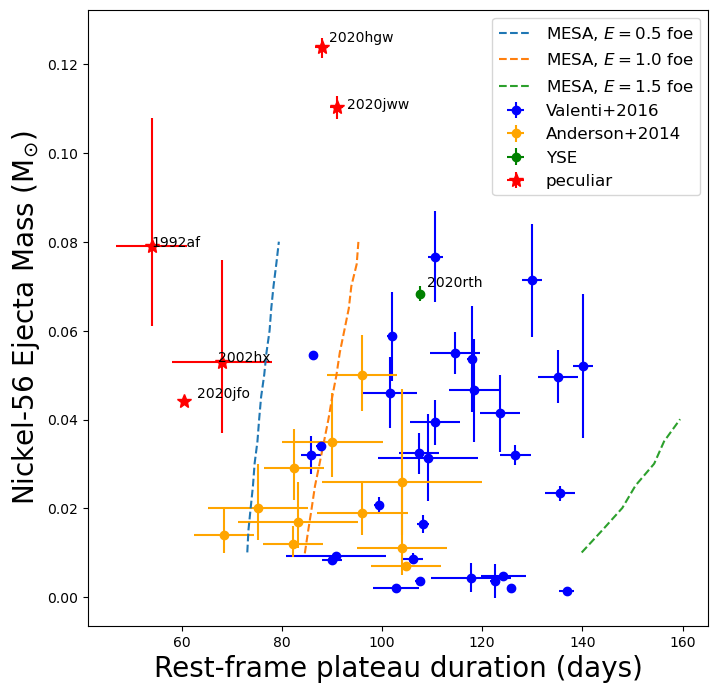

In [100]:
def make_plot(all_data, param1='', param2=''):
    fig, ax = plt.subplots(figsize=(8,8))

    key1=keywords[param1]['key']
    key2=keywords[param2]['key']
    ekey1=keywords[param1]['errkey']
    ekey2=keywords[param2]['errkey']
    colors = {'valenti':'blue', 'anderson':'orange', 'yse':'green', 'peculiar':'red', 'martinez':'gray', 'spiro':'black'}
    
    for key in all_data.keys():
        table = all_data[key]
        if key1 in table.keys() and key2 in table.keys() and ekey1 in table.keys() and ekey2 in table.keys():
            xerr = np.array(table[ekey1].data)
            yerr = np.array(table[ekey2].data)
            
            t1 = table[key1]
            t2 = table[key2]
            mask = ~np.isnan(t1) & ~np.isnan(t2)
            t1 =t1[mask]
            t2 = t2[mask]
            # rval = pr(t1, t2)
            # r_sq = rval[0]**2
            # r_sq = '%.4f'%r_sq
            if len(xerr.shape)==2:
                xerr = xerr.transpose()
            if len(yerr.shape)==2:
                yerr = yerr.transpose()
            if key == 'peculiar':
                ax.errorbar(table[key1], table[key2], xerr=xerr, yerr=yerr, label =table.meta['sample_name'], fmt ='*', markersize = 10, color = colors[key])
            else:
                ax.errorbar(table[key1], table[key2], xerr=xerr, yerr=yerr, label=table.meta['sample_name'], fmt='o', color = colors[key])
                # ax.text(table[key1].min(), 0, f'$r^2 =${r_sq}')

    ax.set_xlabel(keywords[param1]['latex'], fontsize = 20)
    ax.set_ylabel(keywords[param2]['latex'], fontsize = 20)

    return(fig, ax)

fig, ax = make_plot(all_data, 'plateau_duration', 'nickel_mass')

# MESA theoretical data from: https://www.aanda.org/articles/aa/pdf/2020/10/aa38393-20.pdf
# Odd columns are Ni-56 and even columns are plateau duration
colors = ['blue','green','red']
for i,file in enumerate(sorted(glob.glob(os.path.join('data','theory','mesa_nickel*.txt')))):
    filebase = os.path.basename(file)
    value = float(filebase.split('_')[-1].replace('.txt','').replace('foe',''))

    theory_table = Table.read(file, names=('MNi','Tpt'), format='ascii')

    ax.plot(theory_table['Tpt'], theory_table['MNi'], linestyle='dashed', label=f'MESA, $E={value}$ foe')
    
ax.text(63, 0.045, '2020jfo')
ax.text(89.5, 0.125, '2020hgw')
ax.text(93, 0.11, '2020jww')
ax.text(109, 0.07, '2020rth')
ax.legend(fontsize = 'large')
ax.text(54, 0.079, '1992af')
ax.text(67.3, 0.053, '2002hx')

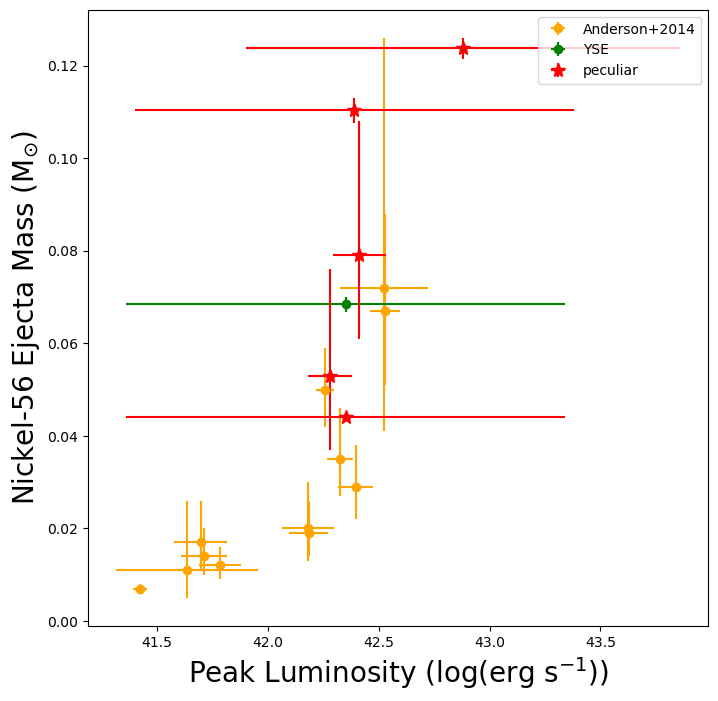

In [101]:
fig, ax = make_plot(all_data, 'peak_luminosity', 'nickel_mass')
plt.legend()

In [102]:
import requests

def get_blast_data(name, suppress_output=False):
    fname=os.path.join('data','blast',name+'.json')
    if os.path.exists(fname):
        with open(fname, 'r') as f:
            data = json.load(f)
            return(data)
    else:
        url = f'https://blast.scimma.org/api/transient/get/{name}'
        r = requests.get(url)
        if r.status_code==200:
            data = json.loads(r.content)
            with open(fname, 'w') as f:
                json.dump(data, f)
        else:
            if not suppress_output: print(f'Could not get Blast data for: {name}')

Redshift for 2013ai is missing
Redshift for 2013bu is missing
Could not get Blast data for: LSQ13dpa
Redshift for 2014dw is missing
Could not get Blast data for: LSQ14gv
Could not get Blast data for: ASASSN-14dq
Could not get Blast data for: ASASSN-14gm
Could not get Blast data for: ASASSN-14ha
Redshift for 2015W is missing
Redshift for 1987A is missing
Redshift for 1990E is missing
No local aperture for 2001X
Redshift for 2002hh is missing
Redshift for 2003hn is missing
Redshift for 2004et is missing
Redshift for 2005cs is missing
Redshift for 2007it is missing
Redshift for 2009bw is missing
Redshift for 2009dd is missing
Redshift for 2012A is missing
Could not get Blast data for: LSQ13dpa
Could not get Blast data for: LSQ14gv
Could not get Blast data for: ASASSN-14dq
Could not get Blast data for: ASASSN-14gm
Could not get Blast data for: ASASSN-14ha
Redshift for 1997D is missing
Redshift for 1999br is missing
Redshift for 2001dc is missing
Redshift for 2004et is missing
Redshift for 

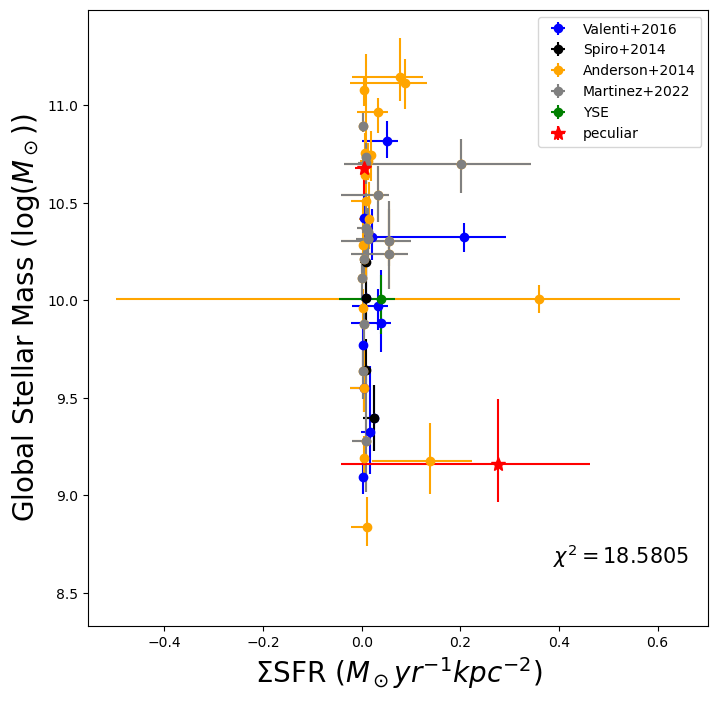

In [103]:
def get_local_sfd(data, suppress_output=False):

    # Return a contextual error to flag objects that need to be re-run
    error = ''
    
    # Get area of local aperture in kpc^2
    redshift = data['host_redshift']
    if redshift is None:
        name = data['transient_name']
        if not suppress_output: print(f'Redshift for {name} is missing')
        return(np.nan, (np.nan, np.nan), 'redshift')
        
    a = data['local_aperture_semi_major_axis_arcsec']
    b = data['local_aperture_semi_minor_axis_arcsec']

    if a is None or b is None:
        name = data['transient_name']
        if not suppress_output: print(f'No local aperture for {name}')
        return(np.nan, (np.nan, np.nan), 'local_aperture')

    d = cosmo.angular_diameter_distance(redshift).value * 1000.0 # Convert to kpc
    area = np.pi * a/3600 * np.pi/180.0 * d * b/3600 * np.pi/180.0 * d

    # Get local star-formation rate
    val = data['local_aperture_host_log_sfr_50']
    if val is None:
        return(np.nan, (np.nan, np.nan), 'local_aperture')

    val = 10**val
    
    eup = 10**data['local_aperture_host_log_sfr_84'] - val
    elo = val - 10**data['local_aperture_host_log_sfr_16']

    val = val / area
    unc = (eup/area, elo/area)
    
    

    return(val, unc, error)
    

def make_blast_plot(all_data, param1, param2, suppress_output=False):
    fig, ax = plt.subplots(figsize=(8,8))

    blast1=False
    blast2=False

    blast_errors = {}
    all_x = []
    all_y = []
    all_xerr_upper = []
    all_xerr_lower = []
    all_yerr_upper = []
    all_yerr_lower = []
    colors = {'valenti':'blue', 'anderson':'orange', 'yse':'green', 'peculiar':'red', 'martinez':'gray', 'spiro':'black'}

    if param1 in keywords.keys():
        key1=keywords[param1]['key']
        ekey1=keywords[param1]['errkey']
        latex1=keywords[param1]['latex']
    elif param1.startswith('global') or param1.startswith('local'):
        latex1=blast_keywords[param1]['latex']
        blast1=True
    if param2 in keywords.keys():
        key2=keywords[param2]['key']
        ekey2=keywords[param2]['errkey']
        latex2=keywords[param2]['latex']
    elif param2.startswith('global') or param2.startswith('local'):
        latex2=blast_keywords[param2]['latex']
        blast2=True

    for key in all_data.keys():
        table = all_data[key]

        if not blast1 and key1 in table.keys() and ekey1 in table.keys():
            x = np.array(table[key1].data)
            xerr = np.array(table[ekey1].data)

        elif blast1:
            x = [] ; xerr = []
            for row in table:
                data = get_blast_data(row['Name'], suppress_output=suppress_output)

                if data is None:
                    if row['Name'] not in blast_errors.keys():
                        blast_errors[row['Name']]='missing'
                    x.append(np.nan)
                    xerr.append((np.nan, np.nan))
                    continue

                if param1=='local_sfd':
                    val, unc, error = get_local_sfd(data, suppress_output=suppress_output)
                    if error:
                        if row['Name'] not in blast_errors.keys():
                            blast_errors[row['Name']]=error
                else:
                    val = data[param1+'_50']
                    if val is None:
                        x.append(np.nan)
                        xerr.append((np.nan, np.nan))
                        continue
                    eup = data[param1+'_84']-val
                    elo = val - data[param1+'_16']
                    unc = (eup, elo)

                x.append(val)
                xerr.append(unc)
                
        else:
            continue

        if not blast2 and key2 in table.keys() and ekey2 in table.keys():
            y = np.array(table[key2].data)
            yerr = np.array(table[ekey2].data)

        elif blast2:
            y = [] ; yerr = []
            for row in table:
                data = get_blast_data(row['Name'], suppress_output=suppress_output)

                if data is None:
                    if row['Name'] not in blast_errors.keys():
                        blast_errors[row['Name']]='missing'
                    y.append(np.nan)
                    yerr.append((np.nan, np.nan))
                    continue

                if param2=='local_sfd':
                    val, unc, error = get_local_sfd(data, suppress_output=suppress_output)
                    if error:
                        if row['Name'] not in blast_errors.keys():
                            blast_errors[row['Name']]=error
                            
                elif param2 == 'local_aperture_host_log_age':
                    val = data['local_aperture_host_log_age_50']
                    if val is None:
                        y.append(np.nan)
                        yerr.append((np.nan, np.nan))
                        continue
                    elif val < 1.5:
                        y.append(np.nan)
                        yerr.append((np.nan, np.nan))
                        continue
                    else:
                        eup = data['local_aperture_host_log_age_84'] - val
                        elo = val -data['local_aperture_host_log_age_16']   
                        unc = (eup, elo)
                    
                else:
                    val = data[param2+'_50']
                    if val is None:
                        y.append(np.nan)
                        yerr.append((np.nan, np.nan))
                        continue
                    eup = data[param2+'_84']-val
                    elo = val - data[param2+'_16']
                    unc = (eup, elo)

                y.append(val)
                yerr.append(unc)
        else:
            continue

        xerr = np.array(xerr)
        yerr = np.array(yerr)

        if len(xerr.shape)==2:
            xerr = xerr.transpose()
        if len(yerr.shape)==2:
            yerr = yerr.transpose()
        
        
        x1 = np.array(x)
        y1 = np.array(y)
        x1err = np.array(xerr)
        y1err = np.array(yerr)
        
        mask = ~np.isnan(x1) & ~np.isnan(y1)
        x1 =x1[mask]
        y1 = y1[mask]
        
        all_x.extend(x1)
        all_y.extend(y1)

        if len(x1err.shape)==2:
            x1err = x1err[:,mask]
            all_xerr_upper.extend(x1err[0,:])
            all_xerr_lower.extend(x1err[1,:])
        else:
            x1err = x1err[mask]
            all_xerr_upper.extend(x1err)
            all_xerr_lower.extend(x1err)

        if len(y1err.shape)==2:
            y1err = y1err[:,mask]
            all_yerr_upper.extend(y1err[0,:])
            all_yerr_lower.extend(y1err[1,:])
        else:
            y1err = y1err[mask]
            all_yerr_upper.extend(y1err)
            all_yerr_lower.extend(y1err)
            
        if key == 'peculiar':
            ax.errorbar(x, y, xerr=xerr, yerr=yerr, label=table.meta['sample_name'], fmt='*', markersize= 10, color = colors[key])
        else:
            ax.errorbar(x, y, xerr=xerr, yerr=yerr, label=table.meta['sample_name'], fmt='o', color = colors[key])

    all_x = np.array(all_x)
    all_y = np.array(all_y)
    all_xerr_upper = np.array(all_xerr_upper)
    all_xerr_lower = np.array(all_xerr_lower)
    all_yerr_upper = np.array(all_yerr_upper)
    all_yerr_lower = np.array(all_yerr_lower)

    with open(f'{param1}_vs_{param2}.csv','w') as f:
        f.write(f'{param1},{param1}_err_upper,{param1}_err_lower,{param2},{param2}_err_upper,{param2}_err_lower \n')
        for i in np.arange(len(all_x)):
            f.write(f'{all_x[i]},{all_xerr_upper[i]},{all_xerr_lower[i]},{all_y[i]},{all_yerr_upper[i]},{all_yerr_lower[i]}\n')

    from scipy.odr import ODR, Model, Data, RealData

    all_xerr_val = np.array([np.max([all_xerr_upper[i],all_xerr_lower[i]]) for i in np.arange(len(all_x))])
    all_yerr_val = np.array([np.max([all_yerr_upper[i],all_yerr_lower[i]]) for i in np.arange(len(all_y))])

    def linear(beta, x):
        return(beta[0]+beta[1]*x)

    data = RealData(all_x, all_y, sx=all_xerr_val, sy=all_yerr_val)
    model = Model(linear)

    odr = ODR(data, model, [1,0])
    odr.set_job(fit_type=2)
    output = odr.run()

    #r_sq = output.cov_beta[1,1]/np.sum(all_xerr_val*all_yerr_val)
    r_sq = '%.4f'%output.res_var
    
    ax.text(0.75, 0.1, f'$\chi^2 = ${r_sq}', transform=ax.transAxes, fontsize = 15)

    ax.set_xlabel(latex1, fontsize = 20)
    ax.set_ylabel(latex2, fontsize = 20)

    return(fig, ax, blast_errors)
    

fig, ax, errors = make_blast_plot(all_data, 'local_sfd', 'global_aperture_host_log_mass')
plt.legend()

In [104]:
yse_transients_ref = Table.read(os.path.join('data','transients.ref'), format='ascii')

outfile = open('blast_missing.txt', 'w')

for key in errors.keys():
    if errors[key]=='missing':
        mask = yse_transients_ref['name']==key
        if len(yse_transients_ref[mask])==1:
            ra = yse_transients_ref[mask][0]['ra']
            dec = yse_transients_ref[mask][0]['dec']
            print(key, ra, dec)
            outfile.write(f'{key} {ra} {dec} \n')
outfile.close()

2006iw 350.331166666667 0.25975
2008ho 36.2666666666667 -24.8006666666667
2009au 194.941666666667 -29.6020833333333
1992af 307.667708333333 -42.3097777777778


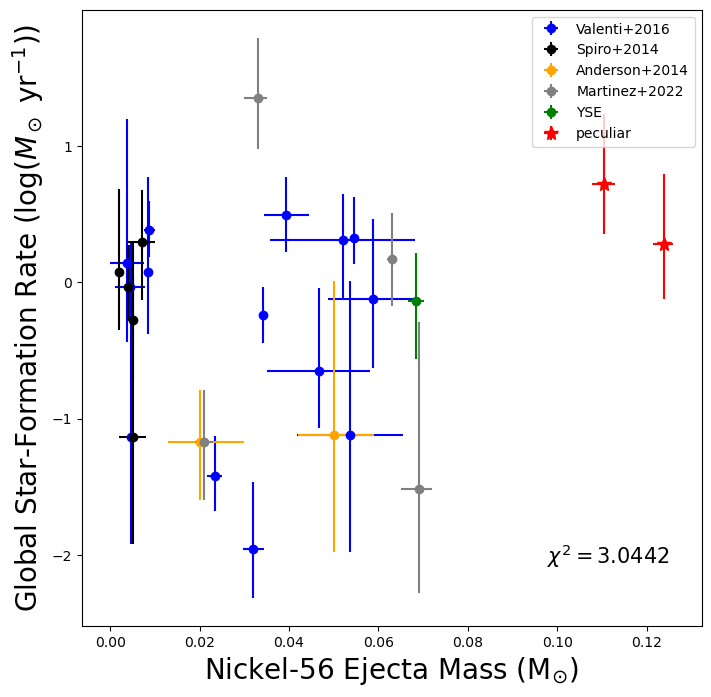

In [105]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass','global_aperture_host_log_sfr', suppress_output=True)
plt.legend()

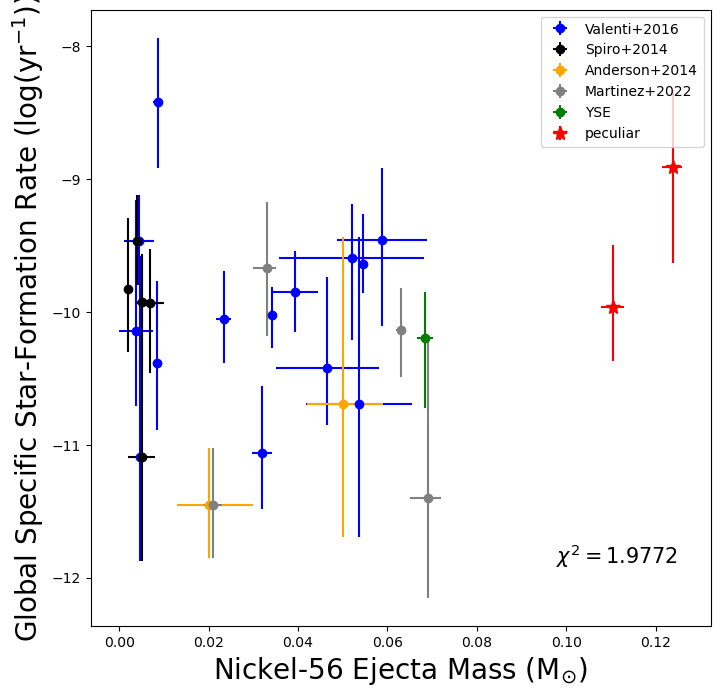

In [106]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass','global_aperture_host_log_ssfr', suppress_output=True)
plt.legend()

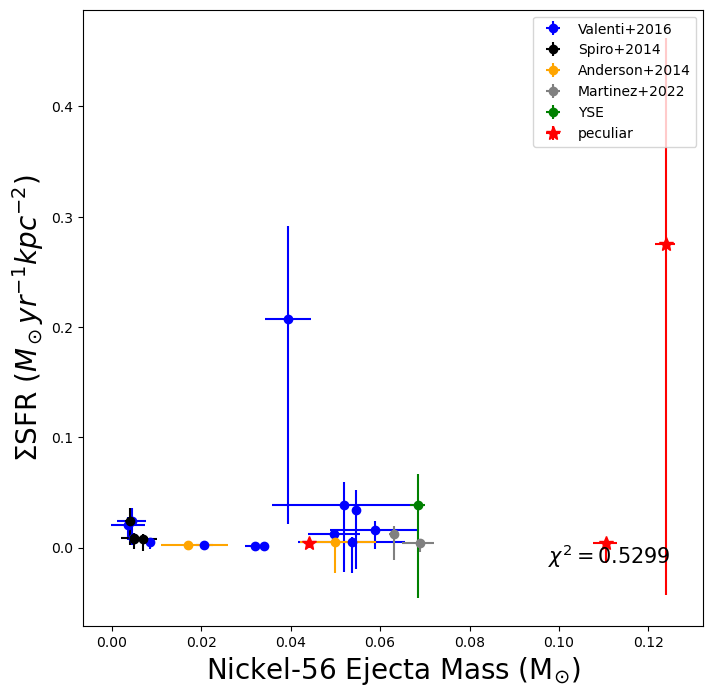

In [107]:
fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'local_sfd', suppress_output=True)
plt.legend()

In [108]:
# fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'global_aperture_host_log_sfr', suppress_output=True)
# plt.legend()

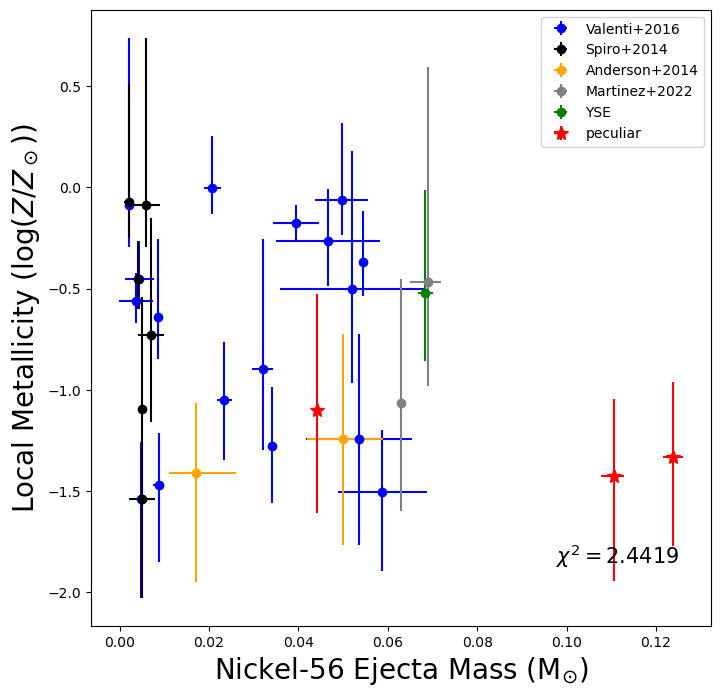

In [109]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass', 'local_aperture_host_logzsol', suppress_output=True)
plt.legend()

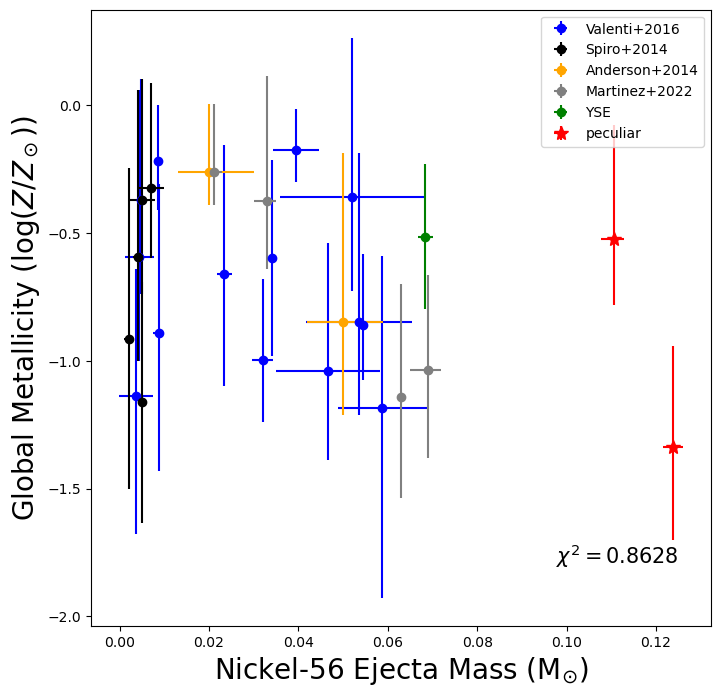

In [110]:
fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'global_aperture_host_logzsol', suppress_output=True)
plt.legend()

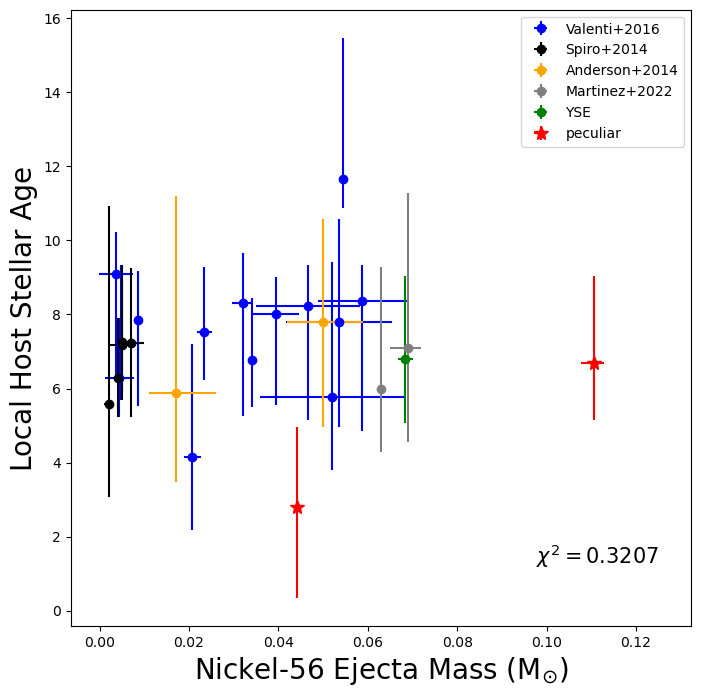

In [111]:
make_blast_plot(all_data, 'nickel_mass', 'local_aperture_host_log_age', suppress_output=True)
plt.legend()

Could not get Blast data for: LSQ13dpa
Could not get Blast data for: LSQ14gv
Could not get Blast data for: ASASSN-14dq
Could not get Blast data for: ASASSN-14gm
Could not get Blast data for: ASASSN-14ha
Could not get Blast data for: 2005gk
Could not get Blast data for: 2006iw
Could not get Blast data for: 2008ho
Could not get Blast data for: 2009au
Could not get Blast data for: 1992af


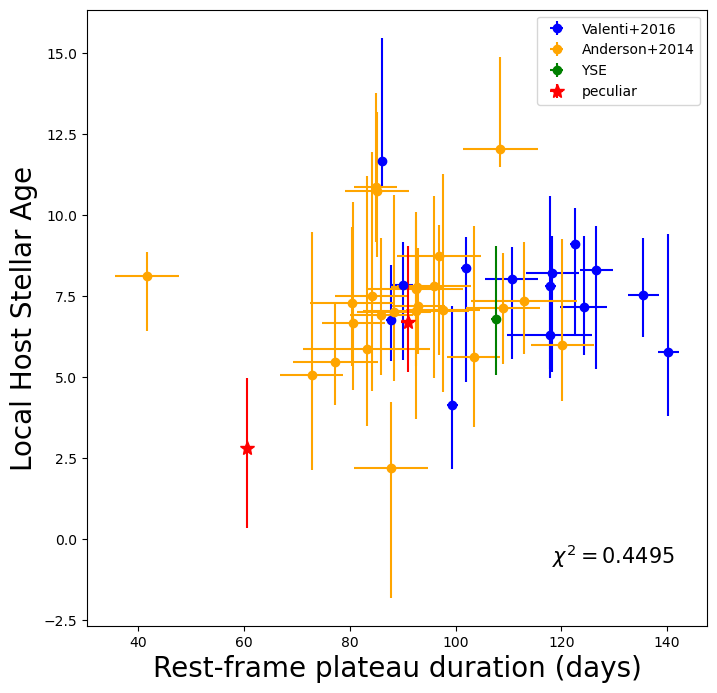

In [112]:
make_blast_plot(all_data, 'plateau_duration', 'local_aperture_host_log_age')
plt.legend()

In [113]:
all_data.values()

dict_values([<Table length=39>
    Name    logL1(0)    S1     e_S1  n_e_S1 ...   E_M0    e_M0     P0   FMT 
   str11    float64  float64 float64  str1  ...  object  object  object str1
----------- -------- ------- ------- ------ ... ------- ------- ------- ----
     2013ai    41.62 -0.0081  0.0001     -- ...    None    None    None    o
     2013bu    41.24 -0.0044  0.0003     -- ... 0.00011  0.0001 -0.0038    o
     2013fs    42.47 -0.0146  0.0009     -- ...  0.0001   9e-05 -0.0038    o
   LSQ13dpa    42.02 -0.0042  0.0006     -- ...   7e-05  0.0001 -0.0038    o
     2014cy    41.66  -0.006  0.0005     -- ...  0.0001  0.0001 -0.0038    o
     2014dw    42.23 -0.0135  0.0005     -- ... 0.00011  0.0001 -0.0058    o
    LSQ14gv    42.19 -0.0081  0.0014     -- ...    None    None    None    o
ASASSN-14dq    42.36 -0.0098  0.0004     -- ... 0.00011  0.0001 -0.0038    o
ASASSN-14gm     42.1  -0.003  0.0003     -- ... 0.00011  0.0001 -0.0028    o
ASASSN-14ha    41.28 -0.0093  0.0003     -- .